# Using aligned ELMo sentence embeddings for multilingual Offensive/Hateful speach classification

In [1]:
from pprint import pprint
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from elmoformanylangs import Embedder
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
en_si_train, en_si_test = train_test_split(pd.concat([
    pd.read_csv("data/ours/en-si.tsv", sep="\t"),
    pd.read_csv("data/non-processed/dataset7/slv.txt", sep="\t", header=None, usecols=[0, 1], names=["EN", "SI"]),
]).dropna(), test_size=0.05)

en_si_train.head()

,EN,SI
75,It's a very hot day.,Zelo vroč dan je.
1686,tackle,reševanje
803,horse,konj
2027,beware,pozor
985,she appears today,ona se danes pojavi/ona se danes zdi


In [3]:
class ELMoEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, path, batch_size=64):
        self.elmo = Embedder(path, batch_size=batch_size)

    def fit(self, X, y = None):
        pass

    def transform(self, X, y = None):
        return np.stack([np.mean(e, axis=0) for e in self.elmo.sents2elmo([sentence.split(" ") for sentence in X], output_layer=0)])

## Load pretrained ELMo models
https://github.com/HIT-SCIR/ELMoForManyLangs

In [4]:
elmo_si_embedder = ELMoEmbedder("checkpoints/elmoformanylanguages/si", 16)
elmo_en_embedder = ELMoEmbedder("checkpoints/elmoformanylanguages/en", 16)

2021-05-20 19:55:34,208 WARNING: Could not find config.  Trying checkpoints/elmoformanylanguages/si/cnn_50_100_512_4096_sample.json
2021-05-20 19:55:34,209 WARNING: Could not find config.  Trying /home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/elmoformanylangs/configs/cnn_50_100_512_4096_sample.json
2021-05-20 19:55:34,222 INFO: char embedding size: 1991
2021-05-20 19:55:35,410 INFO: word embedding size: 257603
2021-05-20 19:55:41,516 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(257603, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(1991, 50, padding_idx=1988)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, ker

In [5]:
si_embeddings_train = elmo_si_embedder.transform(en_si_train["SI"].tolist())
en_embeddings_train = elmo_en_embedder.transform(en_si_train["EN"].tolist())

si_embeddings_test = elmo_si_embedder.transform(en_si_test["SI"].tolist())
en_embeddings_test = elmo_en_embedder.transform(en_si_test["EN"].tolist())

2021-05-20 19:55:48,054 INFO: 154 batches, avg len: 3.9
2021-05-20 19:55:49,239 INFO: Finished 1000 sentences.
2021-05-20 19:55:50,164 INFO: Finished 2000 sentences.
2021-05-20 19:55:51,011 INFO: 154 batches, avg len: 4.0
2021-05-20 19:55:51,968 INFO: Finished 1000 sentences.
2021-05-20 19:55:52,850 INFO: Finished 2000 sentences.
2021-05-20 19:55:53,417 INFO: 9 batches, avg len: 3.7
2021-05-20 19:55:53,576 INFO: 9 batches, avg len: 3.9


## Train embedding alignment model
LR model to align ELMo emebeddings & PCA to visuaize them

In [6]:
lr = LinearRegression()
lr.fit(si_embeddings_train, en_embeddings_train)

LinearRegression()

In [7]:
pca = PCA(n_components=2)
pca.fit(en_embeddings_train)

PCA(n_components=2)

## Evaluate embedding alignments

In [8]:
def plot_pca(pca, embeddings, verbs, top=10, label=None):
    embeddings_pca = pca.transform(embeddings)
    plt.scatter(embeddings_pca[:top,0], embeddings_pca[:top,1], label=label)
    for i, text in enumerate(verbs[:top]):
        plt.annotate(text, (embeddings_pca[i,0], embeddings_pca[i,1]))

def plot_alignment_errors(pca, e1, e2, top=10):
    e1_pca = pca.transform(e1)
    e2_pca = pca.transform(e2)
    for i in range(top):
        plt.plot([e1_pca[i,0], e2_pca[i,0]], [e1_pca[i,1], e2_pca[i,1]], linestyle="--", linewidth=1, alpha=0.5, color="gray", label="error" if i == 0 else None)

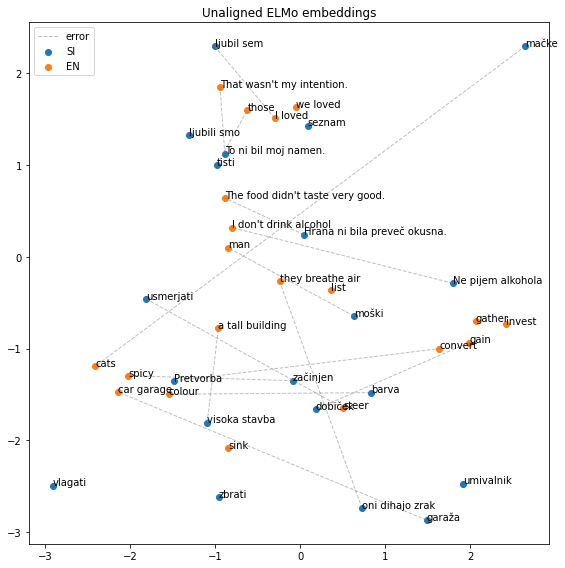

In [9]:
plt.figure(figsize=(8,8))
plot_pca(pca, si_embeddings_test, en_si_test["SI"].tolist(), top=20, label="SI")
plot_pca(pca, en_embeddings_test, en_si_test["EN"].tolist(), top=20, label="EN")
plot_alignment_errors(pca, si_embeddings_test, en_embeddings_test, top=15)
plt.title("Unaligned ELMo embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("results/eval-elmo-alignment-unaligned-embeddings.pdf")

In [10]:
si_embeddings_test_aligned = lr.predict(si_embeddings_test)

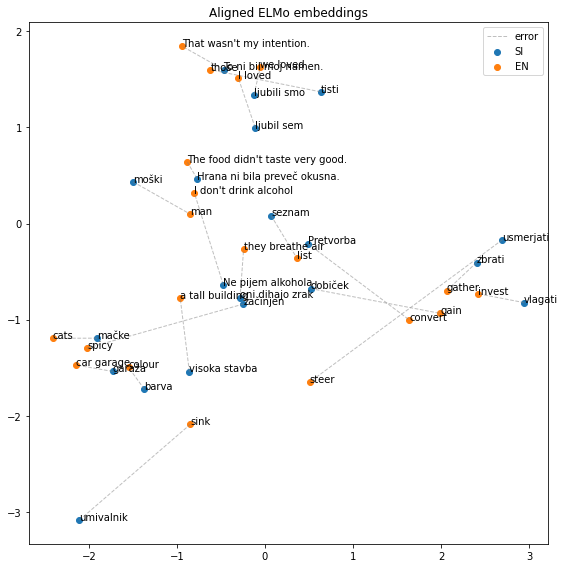

In [11]:
plt.figure(figsize=(8,8))
plot_pca(pca, si_embeddings_test_aligned, en_si_test["SI"].tolist(), top=20, label="SI")
plot_pca(pca, en_embeddings_test,         en_si_test["EN"].tolist(), top=20, label="EN")
plot_alignment_errors(pca, si_embeddings_test_aligned, en_embeddings_test, top=20)
plt.title("Aligned ELMo embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("results/eval-elmo-alignment-aligned-embeddings.pdf")

## Train Offensive/Hateful speach classification models

In [12]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower()
    return text

def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df.columns = ["text", "labels"]
    data_df["text"] = data_df["text"].map(clean_text)

    return data_df

def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["text"] = data_df["content"].map(clean_text)
    data_df["labels"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")

    data_df = data_df.drop(columns=set(data_df.columns) - {"text", "labels"})

    return data_df

train_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/english_dataset.tsv")

test_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv")
# test_de_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv")
# test_hi_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv")
_, test_si_df = train_test_split(load_senti_news_dataset("/hdd/matjazibb/dataset/senti-news/SentiNews_sentence-level.txt"), test_size=0.005)

In [13]:
def elmo_chunked(elmo_embedder, sentences, n_chunks):
    embeddings = []
    for chunk in tqdm(np.array_split(sentences, n_chunks)):
        elmo = elmo_embedder.transform(chunk.tolist())
        embeddings += [e for e in elmo]
    return embeddings

In [14]:
train_en_df["embedding"] = elmo_chunked(elmo_en_embedder, train_en_df["text"], 10)

test_en_df["embedding"] =  elmo_chunked(elmo_en_embedder, test_en_df["text"], 10)
test_si_df["embedding"] =  elmo_chunked(elmo_si_embedder, test_si_df["text"], 10)


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [15]:
test_si_df["embedding_aligned"] = [e for e in lr.predict(np.stack(test_si_df["embedding"]))]

In [16]:
logistic_regression = LogisticRegression(class_weight="balanced", max_iter=1000)
logistic_regression.fit(np.stack(train_en_df["embedding"]), train_en_df["labels"].to_numpy())

LogisticRegression(class_weight='balanced', max_iter=1000)

In [17]:
random_forest = RandomForestClassifier(class_weight="balanced")
random_forest.fit(np.stack(train_en_df["embedding"]), train_en_df["labels"].to_numpy())

RandomForestClassifier(class_weight='balanced')

In [19]:
def eval_model(model, X, y_true):
    y_hat = model.predict(X)
    p_hat = model.predict_proba(X)

    assert model.classes_[0] == "HOF"
    p_hat = p_hat[:,0]
    
    f1 = sklearn.metrics.f1_score(y_true, y_hat, pos_label="HOF")
    precision = sklearn.metrics.precision_score(y_true, y_hat, pos_label="HOF")
    recall = sklearn.metrics.recall_score(y_true, y_hat, pos_label="HOF")
    fpr, tpr, t = sklearn.metrics.roc_curve(y_true, p_hat, pos_label="HOF")
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, precision, recall, roc_auc, fpr, tpr

In [20]:
eval_models = [
    ("LogReg-HASOC-en",             logistic_regression,    np.stack(test_en_df["embedding"]),              test_en_df["labels"]),
    ("LogReg-SentiNews-si",         logistic_regression,    np.stack(test_si_df["embedding"]),              test_si_df["labels"]),
    ("LogReg-SentiNews-si-aligned", logistic_regression,    np.stack(test_si_df["embedding_aligned"]),      test_si_df["labels"]),

    ("RanFor-HASOC-en",             random_forest,          np.stack(test_en_df["embedding"]),              test_en_df["labels"]),
    ("RanFor-SentiNews-si",         random_forest,          np.stack(test_si_df["embedding"]),              test_si_df["labels"]),
    ("RanFor-SentiNews-si-aligned", random_forest,          np.stack(test_si_df["embedding_aligned"]),      test_si_df["labels"]),
]

results = []

for model_name, model, X, y_true in eval_models:
    f1, precision, recall, roc_auc, fpr, tpr = eval_model(model, X, y_true)
    results += [(model_name, f1, precision, recall, roc_auc, fpr, tpr)]

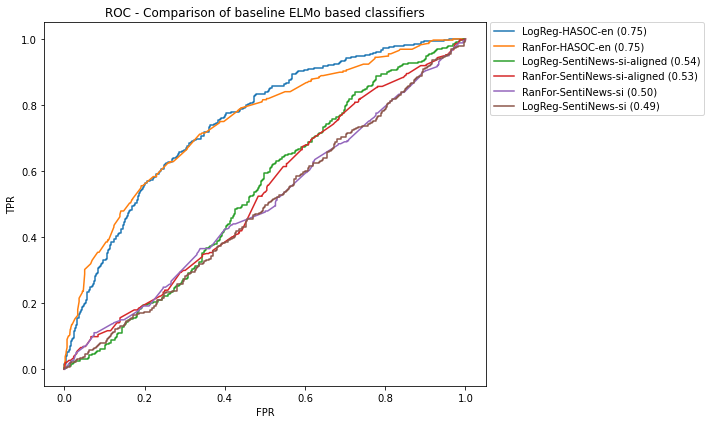

In [21]:
plt.figure(figsize=(10,6))
for model_name, f1, precision, recall, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[4], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline ELMo based classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.savefig("results/eval-elmo-alignment-rocs.pdf")

In [22]:
results_df = pd.DataFrame(results, columns=["model_name", "f1", "precision", "recall", "roc_auc", "fpr", "tpr"])
results_df.to_csv("results/eval-elmo-alignment.csv", index=False)
results_df.head(30)

,model_name,f1,precision,recall,roc_auc
0,LogReg-HASOC-en,0.507830,0.374587,0.788194,0.748174
1,LogReg-SentiNews-si,0.097938,0.351852,0.056886,0.489506
2,LogReg-SentiNews-si-aligned,0.375199,0.400000,0.353293,0.535196
3,RanFor-HASOC-en,0.441558,0.586207,0.354167,0.745171
4,RanFor-SentiNews-si,0.208617,0.429907,0.137725,0.500384
5,RanFor-SentiNews-si-aligned,0.051576,0.600000,0.026946,0.527365


In [23]:
%reset